In [2]:
##### Importo librerias necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import re
# import jenkspy
import datetime as dt
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
from datetime import timedelta
import glob as glob
import warnings
import os
warnings.filterwarnings("ignore", category=FutureWarning)
import zipfile
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
path="//10.1.1.7/01 Oficina Planeación y Control/01 Analytics/Stiven/Movil/"
os.chdir(path)
now=dt.datetime.now().strftime('%Y%m%d')
now2=dt.datetime.now().strftime('%Y-%m-%d')
today = dt.date.today()
def condition():
    if today.strftime("%A")=='Monday':
        return (today - dt.timedelta(days=2)).strftime('%Y%m%d')      
    else:
        return (today - dt.timedelta(days=1)).strftime('%Y%m%d')
yesterday=condition()
os.chdir(path)
os.getcwd()
############################################ Funciones para cargue  ########################################################
def open_files_hoy(paths):
        data = []
        for path1 in paths:
            zf = zipfile.ZipFile(path1)#Función de apertura de .zip
            data.append(pd.read_csv(#Función de lectura paralelizada
                        zf.open(zf.filelist[0].filename),#Abre el primer archivo del .zip
                        sep = "|", ## separación del archivo CSV
                        encoding = "utf-8",
                        dtype=str ## Leo todo en formato object,
                        )
                    )
        print(path,"Cargado!")
        return pd.concat(data,ignore_index = True)

### load databases

In [3]:
file_paths=glob.glob("Y:/Stiven/Movil/Cobranzas_movil_(Despliegue)/Download_folder_Adminfo/*_IGC.zip")
igc = open_files_hoy(file_paths[:])
pagos=pd.read_csv("Y:\Stiven\Movil\Cobranzas_movil_(Despliegue)\concatenado_IGC_completo_pruebas.csv",sep=';',encoding='utf-8',dtype=str)
seg=pd.read_csv(r"Y:\Stiven\Movil\Cobranzas_movil_(Despliegue)\asesores_concatenada.csv",sep=';',encoding='utf-8',dtype=str)
consolidado_ig=pd.read_csv(r'Y:\Stiven\Movil\Cobranzas_movil_(Despliegue)\concatenado_IGC_completo_pruebas.csv',sep=';',encoding='utf-8',dtype=str)

//10.1.1.7/01 Oficina Planeación y Control/01 Analytics/Stiven/Movil/ Cargado!


### Se crean variabels y se concatenan

In [4]:
igc["ESTATUS1"] =\
    np.where(igc["Número Traslado"].str.contains("23213|23214|23619",regex = True,na = False),"B2B MOVIL","B2C MOVIL")
igc['Fecha Asignación']=pd.to_datetime(igc['Fecha Asignación'],format='%Y-%m-%d',errors='coerce')
igc['Fecha Ultima Gestión ']=pd.to_datetime(igc['Fecha Ultima Gestión '],format='%Y-%m-%d',errors='coerce')
igc['DIAS SIN GESTION']=(dt.datetime.now()-igc['Fecha Ultima Gestión ']).dt.days
igc=pd.concat([consolidado_ig,igc])


In [5]:
igc=igc[consolidado_ig.columns] ## Conservo columnas adicionales
#================================ Create variables and parse dates =================
igc['Fecha Asignación']=pd.to_datetime(igc['Fecha Asignación'],format='%Y-%m-%d')
igc=igc.sort_values(['Identificación','Referencia Pago','Fecha Asignación'],ascending=True)
igc['llave']=igc['Referencia Pago']+"_"+igc['Fecha Asignación'].astype(str)
igc.drop_duplicates(['llave'],keep='last',inplace=True)
igc['Fecha Churn']=igc['Fecha Churn'].astype(str)
igc['Fecha Churn']=igc['Fecha Churn'].str.replace('(.*)\s.*', '\\1').str.replace('-','')
igc['Fecha Churn']=pd.to_datetime(igc['Fecha Churn'],format='%Y%m%d',errors='coerce')
igc['Marca Portafolio']=igc['Marca Portafolio'].str.strip()
igc['Antiguedad de Producto']=igc['Antiguedad de Producto'].str.replace('AntiguÃ³','Antigua').str.replace('En MaduraciÃ³n','En maduración')
igc['Fecha Asignación']=igc['Fecha Asignación'].astype(str).str.replace('(.*)\s.*', '\\1').str.replace('-','')
igc['Fecha Asignación']=pd.to_datetime(igc['Fecha Asignación'],format='%Y-%m-%d',errors='coerce')
igc['Fecha Asignación_año_mes']=(igc['Fecha Asignación'].dt.year).astype(str) +"_"+ (igc['Fecha Asignación'].dt.month).astype(str)
igc['Fecha Ultima Gestión ']=pd.to_datetime(igc['Fecha Ultima Gestión '],format='%Y-%m-%d',errors='coerce')
igc['Fecha Creación de Cuenta']=pd.to_datetime(igc['Fecha Creación de Cuenta'],format='%Y-%m-%d',errors='coerce')
igc['meses_desde_creacion']=(igc['Fecha Ultima Gestión ']-igc['Fecha Creación de Cuenta']).dt.days/365
igc['Fecha Actualizacion']=pd.to_datetime(igc['Fecha Actualizacion'],format='%Y-%m-%d',errors='coerce')
igc['DIAS SIN GESTION_act']=(igc['Fecha Actualizacion']-igc['Fecha Ultima Gestión ']).dt.days
#================================= Outliers =======================================
igc['DIAS SIN GESTION_act']=np.where(igc['DIAS SIN GESTION_act'] > igc['DIAS SIN GESTION_act'].quantile(0.95),  igc['DIAS SIN GESTION_act'].quantile(0.95),igc['DIAS SIN GESTION_act'])

In [6]:
## Drop duplicates
igc=igc[~igc.duplicated()]

* Nota para actualizar el modelo y la data
1) Eliminar el filtro ó modificarlo con el objetivo de aumentar la data
2) Verificar constantemente el preescriptivo

In [7]:
### load and merge payment with collection portfolio
file_paths=glob.glob("D:/Proyecto Movil/Pagos/*.zip")
pagos = open_files_hoy(file_paths[:]) 
ig=igc[igc['Fecha Asignación']<='2021-12-01'] ### Filter
pagos['Fecha Pago']=pd.to_datetime(pagos['Fecha Pago'],format='%Y-%m-%d')
############# Delimito fecha con el objetivo de mejorar y evaluar posteriormente el modelo
pag=pagos[pagos['Fecha Pago']<='2021-12-01']
pag=pag[~pag.duplicated()]
pag=pag.sort_values(['Referencia Pago','Fecha Pago','Valor Pago'],ascending=True)
pag=pag.drop_duplicates(['Referencia Pago','Fecha Pago','Valor Pago'],keep='last')
dd=pd.merge(igc,
            pag[['Referencia Pago','Valor Pago', 'Fecha Pago','Identificacion Cliente','Detalle Pago']],
                left_on=['Identificación','Referencia Pago'],
                right_on=['Identificacion Cliente','Referencia Pago'],how='left')

//10.1.1.7/01 Oficina Planeación y Control/01 Analytics/Stiven/Movil/ Cargado!


In [8]:

dd=dd[~dd.duplicated()] ## Elimino duplicados puros
dd['Fecha Pago']=pd.to_datetime(dd['Fecha Pago'],format='%Y-%m-%d',errors='coerce')
dd['diff']=(dd['Fecha Pago']-dd['Fecha Asignación']).dt.days
dd['efectividad']=np.where(~dd['Fecha Pago'].isna(),'Pago','No Pago')
dd['fecha_xra_churn']=(dd['Fecha Churn']-dd['Fecha Asignación']).dt.days

dd['diff']=(dd['Fecha Pago']-dd['Fecha Asignación']).dt.days
col         = 'diff'
col2=         'efectividad'
condi = [(dd[col]<-3) & (dd[col2]=='Pago'),  (dd[col].between(-3,38)) & (dd[col2]=='Pago'),(dd[col2]=='No Pago'),(~dd[col].between(-3,38)) & (dd[col2]=='Pago')]
seg_     = [ "No efectivo", 'efectivo', 'No efectivo','No efectivo'] 
dd["Efectivo_data"] = np.select(condi, seg_, default=np.nan)
dd['Efectivo_data']=(dd['Efectivo_data']=='efectivo').astype(int)
dd["diff_dias_chur_pago"] = (dd["Fecha Churn"] - dd["Fecha Pago"]).dt.days
## ==== Creación historico para alimentar la salida del modelo =====
hist=dd[['Efectivo_data','diff_dias_chur_pago','Fecha Churn','Identificacion Cliente','Valor Pago']]

* Create & clean variables

In [9]:
dd['Valor a Cobrar']=dd['Valor a Cobrar'].astype(float)
dd['Fecha Asignación']=pd.to_datetime(dd['Fecha Asignación'],format='%Y-%m-%d',errors='coerce')
dd['Fecha Asignación_año_mes']=(dd['Fecha Asignación'].dt.year).astype(str) +"_"+ (dd['Fecha Asignación'].dt.month).astype(str)
dd['Fecha Ultima Gestión ']=pd.to_datetime(dd['Fecha Ultima Gestión '],format='%Y-%m-%d',errors='coerce')
dd['Fecha Creación de Cuenta']=pd.to_datetime(dd['Fecha Creación de Cuenta'],format='%Y-%m-%d',errors='coerce')
dd['meses_desde_creacion']=(dd['Fecha Ultima Gestión ']-dd['Fecha Creación de Cuenta']).dt.days/365

* Se eliminan variables que por alta cardinalidad o correlación no ayudan al modelo

In [10]:
dd.drop(['Valor Pago','Facturación Credivalores','Fecha Pago','Region','Codigo regional tigo','Desconciliada','Regional', 'Estado Plan',
        'Identificacion Cliente','Detalle Pago','FLP','Grabador Gestión Masiva',
        'Fecha Gestión Masiva','Valor Cuota','Gastos Cobranza Credivalores','Segmentacion B2B','Segmento Asesor Corporativo','Riesgo Habito de Pago',
        'Cliente Convergente','Billing Status','Fecha Castigo','Estado Financiación','Plan','Gerencia Convergente','Corriente',
        'Subsegmento B2B','Inmunidad B2B','Fecha de suspensión decreto','diff_dias_chur_pago','Segmento',
    'Código departamento','Ciudad','Pago Ajuste No Alocado','Nombre Campaña Especial','Interes Mora Credivalores','Interes Corriente Credivalores'],
        axis=1,inplace=True)

In [11]:
## Se renombra por extensión
dd.rename(columns={'Descripción Código Ult. Gestión':'Desc_codigo_ult_ges','Descripción Traslado':'des_traslado'},inplace=True)
dd['Desc_codigo_ult_ges'].fillna('SIN GESTION',inplace=True)

#### Clean featueres
* Nota: Donde se define la variable de mejro código de gestión hallamos que la lista definida como **c** puede variar de acuerdo a cambios en la operación, s erecomienda validarlo constantemente.

In [12]:
dd['Perfil Digital'].fillna('SIN PERFIL',inplace=True)
dd['Fecha Churn']=dd['Fecha Churn'].astype(str)
dd['Fecha Churn']=dd['Fecha Churn'].str.replace('(.*)\s.*', '\\1').str.replace('-','')
dd['Fecha Churn']=pd.to_datetime(dd['Fecha Churn'],format='%Y%m%d',errors='coerce')
dd['No. Facturas Vencidas']=dd['No. Facturas Vencidas'].astype(int).fillna(0)
dd['No. Cuotas Pactadas'][dd['No. Cuotas Pactadas']==' '] =dd["No. Cuotas Facturadas"].mode()[0] 
dd['No. Cuotas Pactadas'].fillna('SIN DATO',inplace=True)
dd['DIAS SIN GESTION']=dd['DIAS SIN GESTION'].astype(int)
dd['Analisis Vector'][dd['Analisis Vector']==' ']='SIN VECTOR'
dd['Analisis Vector'].fillna('SIN VECTOR',inplace=True)
## por limpiar
dd['Descripcion Mejor Codigo Gestion'][dd['Descripcion Mejor Codigo Gestion']==' ']='SIN GESTION'
c=dd['Descripcion Mejor Codigo Gestion'].value_counts().iloc[:9].index.tolist()
dd['Descripcion Mejor Codigo Gestion']=dd.apply(
    lambda row: row['Descripcion Mejor Codigo Gestion']  if (row['Descripcion Mejor Codigo Gestion'] in c)
    else 'OTRA GESTION',axis=1)
# dd['Calificacion Vector Cliente'][dd['Calificacion Vector Cliente']==' '] = dd['Calificacion Vector Cliente'].value_counts().index[1]
# dd['Calificacion Vector Cliente']=dd['Calificacion Vector Cliente'].astype(float)
dd['Calificacion Vector Servicio'][dd['Calificacion Vector Servicio']==' '] = dd['Calificacion Vector Servicio'].value_counts().index[1]
dd['Calificacion Vector Servicio']=dd['Calificacion Vector Servicio'].replace(' ','50')
dd['Calificacion Vector Servicio']=dd['Calificacion Vector Servicio'].astype(float)
dd['Tipo Plan'].fillna('NO REGISTRA',inplace=True)
## limpieza en departamento, finalmente no se usa
dd['Departamento']=dd['Departamento'].str.upper().str.strip()
dic={'NARIÃ±O':'NARIÑO','NARIÏ¿½O':'NARIÑO','ATLÃ¡NTICO':'ATLANTICO','ATLÏ¿½NTICO':'ATLANTICO','ATL NTICO':'ATLANTICO',
    'ARCHIPIÃ©LAGO DE SAN ANDRÃ©S':'SAN ANDRES','ARCHIPIÏ¿½LAGO DE SAN ANDRÏ¿½S':'SAN ANDRES','NTE DE SANTANDER':'NORTE DE SANTANDER',
    'ARCHIPI LAGO DE SAN ANDR S':'SAN ANDRES','ARCHIPI LAGO DE SAN ANDR S  PROVIDENCIA Y SANTA CATALINA':'SAN ANDRES',
    'BOL VAR':'BOLIVAR','BOLÃ\xadVAR':'BOLIVAR','BOYACÃ¡':'BOYACA','BOYAC':'BOYACA','CÃ³RDOBA':'CORDOBA','C/MARCA':'CUNDINAMARCA',
    'VALL CAUCA':'VALLE DEL CAUCA','CHOCÃ³':'CHOCO','CHOC':'CHOCO','CÏ¿½RDOBA':'CORDOBA','NARI O':'NARIÑO','CAQUET':'CAQUETA',
    'C RDOBA':'CORDOBA','VALLE DEL CAUCA\\T':'VALLE DEL CAUCA','BOLÏ¿½VAR':'BOLIVAR','CAQUETÃ¡':'CAQUETA','N S/TANDER':'NTE DE SANTANDER',
    'BOYACÏ¿½':'BOYACA','GUAINÃ\xadA':'GUAINIA','VAUPÃ©S':'VAUPES','GUAIN A':'GUAINIA','VAUP S':'VAUPES','BOGOT   D.C':'BOGOTA D.C',
    'BOGOT   D.C.':'BOGOTA D.C','BOGOTA D,C':'BOGOTA D.C','BOGOTA':'BOGOTA D.C','BOGOTA DE':'BOGOTA D.C','BOGOTA D.E':'BOGOTA D.C'}
dd['Departamento']=dd['Departamento'].replace(dic)
dd['Departamento']=dd['Departamento'].str.replace('NTE DE SANTANDER','NORTE DE SANTANDER')
# dd['Codigo de Gestion']=dd['Codigo de Gestion'].fillna('NO REGISTRA')
dd['Tipificacion Cliente'][dd['Tipificacion Cliente']==' ']='SIN REGISTRO'
dd['Vector Cualitativo Contrato'][dd['Vector Cualitativo Contrato']==' ']='SIN COMPORTAMIENTO'
dd['Canal B2B'][dd['Canal B2B']==' ']='SIN REGISTRO'
dd['Vector Cualitativo Contrato'].fillna('SIN COMPORTAMIENTO',inplace=True)
dd['Analisis Vector']=dd['Analisis Vector'].str.strip()
dd['Perfil Digital'][dd['Perfil Digital']==' ']='SIN PERFIL'
dd['Perfil Digital'].fillna('SIN PERFIL',inplace=True)
# dd['Estado Localización'].fillna('SIN REGISTRO',inplace=True)
# dd['Estado Localización']=dd['Estado Localización'].str.strip()
dd['Mora 150']=dd['Mora 150'].astype(float)
dd['Mora 180']=dd['Mora 180'].astype(float)
dd['Mora 30']=dd['Mora 30'].astype(float)
dd['Mora 60']=dd['Mora 60'].astype(float)
dd['Mora 90']=dd['Mora 90'].astype(float)
dd['Mora 120']=dd['Mora 120'].astype(float)
dd['Mora 210']=dd['Mora 210'].astype(float)
# dd['Total'].fillna('0',inplace=True)
# dd['Total']=dd['Total'].astype(float)
# dd['Cantidad_recontactos_mes']=dd['Cantidad_recontactos_mes'].fillna('0').astype(float)
dd['Dias Mora']=dd['Dias Mora'].astype(float)
# dd['Valor De Compromiso'][dd['Valor De Compromiso']==' ']=0
# dd['Valor De Compromiso']=dd['Valor De Compromiso'].astype('float')
# dd['recon_mes']=dd['recon_mes'].fillna('0').astype('float')
dd['Canal B2B'][dd['Canal B2B']==' ']='NO REGISTRA'
# dd['Descripcion Causal Mora'].fillna('SIN CAUSAL',inplace=True)
# dd['Descripcion Causal Mora'][dd['Descripcion Causal Mora']==' ']='SIN CAUSAL'
dd.drop(dd.filter(like='echa').columns,axis=1,inplace=True)

C:\Users\scadacat\AppData\Local\Temp/ipykernel_20956/1521017232.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['No. Cuotas Pactadas'][dd['No. Cuotas Pactadas']==' '] =dd["No. Cuotas Facturadas"].mode()[0]
C:\Users\scadacat\AppData\Local\Temp/ipykernel_20956/1521017232.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['Analisis Vector'][dd['Analisis Vector']==' ']='SIN VECTOR'
C:\Users\scadacat\AppData\Local\Temp/ipykernel_20956/1521017232.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [13]:
#========== Create & handle data ===========
dd['Monto Financiado_dummy'] = np.where((dd['Monto Financiado']==" ") | (dd['Monto Financiado']=='0.00'),"0",'1').astype(int)
dd.drop(['Monto Financiado'],axis=1,inplace=True)
dd['Valor a Cobrar']=dd['Valor a Cobrar'].astype(np.float)
dd["efectividad"] = (dd["efectividad"]=="Pago").astype(int)
dd["Validación Recaudo"] = (dd["Validación Recaudo"]=="S").astype(int)
dd['ESTATUS1']= (dd['ESTATUS1']=="B2C MOVIL").astype(int)
# dd['Monto Financiado_dummy'] = np.where((dd['Monto Financiado']==" ") | (dd['Monto Financiado']=='0.00'),"0",'1').astype(int)
# dd.drop(['Monto Financiado'],axis=1,inplace=True)
dd['Valor a Cobrar']=dd['Valor a Cobrar'].astype(np.float)
# dd["efectividad"] = (dd["efectividad"]=="Pago").astype(int)
dd["Estado Cuenta"] = (dd["Estado Cuenta"]=="Activo").astype(int)
dd["Castigada"] = (dd["Castigada"]=="NO").astype(int)
dd['Saldo Vencido']=dd['Saldo Vencido'].astype(float)
dd['Saldo']=dd['Saldo'].astype(float)
## Drop outliers
qs=dd['Saldo Vencido'].quantile(0.98)
dd['Saldo Vencido']= np.where(dd["Saldo Vencido"] > qs, qs ,dd["Saldo Vencido"])
qp=dd['Saldo'].quantile(0.98)
dd['Saldo']= np.where(dd["Saldo"] > qp, qp ,dd["Saldo"])
dd['saldo_ratio']=dd['Saldo']/dd['Saldo Vencido']
dd.drop(['Saldo Vencido','Saldo'],axis=1,inplace=True)
dd.drop(['Mora 90','Mora 150','Mora 180','Mora 210','Identificación', 'Identificación','No. Cuotas Pactadas','No. Facturas Vencidas','Referencia Pago'],axis=1,inplace=True)
dd['No. Cuotas Facturadas']=pd.to_numeric(dd['No. Cuotas Facturadas'],errors='coerce').fillna(dd['No. Cuotas Facturadas'].mode)
dd['Calificacion Vector Cliente']=pd.to_numeric(dd['Calificacion Vector Cliente'],errors='coerce')
dd['Calificacion Vector Cliente'].fillna(dd['Calificacion Vector Cliente'].median(),inplace=True)
dd['Calificacion Vector Servicio'].fillna(dd['Calificacion Vector Servicio'].median(),inplace=True)
dd.drop(['Descripcion Mejor Codigo Gestion','Billing Progress','Mora 300',
        'llave','Ciclo','efectividad','diff','Calificacion Vector Servicio','Departamento'],axis=1,inplace=True)

C:\Users\scadacat\AppData\Local\Temp/ipykernel_20956/2093356954.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dd['Valor a Cobrar']=dd['Valor a Cobrar'].astype(np.float)
C:\Users\scadacat\AppData\Local\Temp/ipykernel_20956/2093356954.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dd['Valor a Cobrar']=dd['Valor a Cobrar'].astype

<AxesSubplot:>

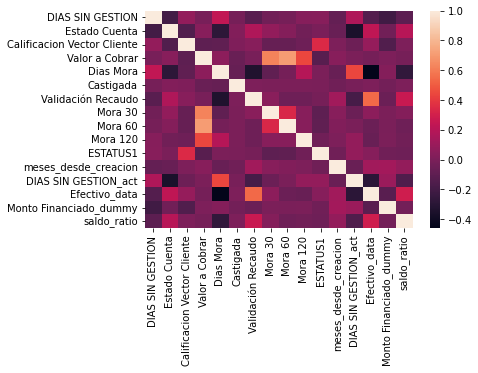

In [14]:
sns.heatmap(dd.corr())

In [15]:
cols=['Valor a Cobrar','Dias Mora',
        'Calificacion Vector Cliente',
        'DIAS SIN GESTION','No. Cuotas Facturadas']
dd['No. Cuotas Facturadas']=pd.to_numeric(dd['No. Cuotas Facturadas'],errors='coerce').fillna(0)
dd['No. Cuotas Facturadas']=dd['No. Cuotas Facturadas'].astype(float)
dd[dd.filter(like='Mora ').columns]=dd[dd.filter(like='Mora ').columns].astype(float)
dd['Antiguedad de Producto']=dd['Antiguedad de Producto'].str.upper().str.translate(str.maketrans('ÁÉÍÓÚ','AEIOU'))\
                        .str.replace('ANTIGUA','ANTIGUO')


* Exporto... y ¿para qué?--> con le fin de ajustar los perfiles (Click para observar el destino)
<!-- dd.columns.to_frame().to_csv('D:\Proyecto Movil\Modelo 2\columnas_antes_consolidar.csv') -->

In [16]:
dic_ges={'COMPROMISO DE PAGO':'PROMESA DE PAGO',
         'MENSAJE CON TERCEROS CASA':'SE DEJO MENSAJE CON TERCERO',
        'PAGO REALIZADO':'YA PAGO','Ã±':'NA'}
dd['Desc_codigo_ult_ges']=dd['Desc_codigo_ult_ges'].str.upper().replace(dic_ges).str.replace('Ã±','N').str.lstrip().str.replace('Ñ','N')
dd['des_traslado']=dd['des_traslado'].str.upper().str.replace('(.*)\_.*', '\\1').str.lstrip()
dd['Autopago'][dd['Autopago']=='Convergente']=np.nan
dd['Autopago'][dd['Autopago']==' ']=np.nan
dd['Tipo Documento']=np.where(dd['Tipo Documento'].isin(['CC','NIT','CE']),dd['Tipo Documento'],"CC")
dd['Canal B2B'][dd['Canal B2B']=='nan']=np.nan
dd['Canal B2B'].fillna('SIN REGISTRO',inplace=True)
dd['Canal B2B'][dd['Canal B2B']=='nan']=np.nan
dd['Canal B2B'].fillna('SIN REGISTRO',inplace=True)
dd['Antiguedad de Producto'][dd['Antiguedad de Producto']=='nan']=np.nan
dd['Antiguedad de Producto'].fillna('SIN REGISTRO',inplace=True)
dd['Marca Portafolio'][dd['Marca Portafolio']=='nan']=np.nan
dd['Marca Portafolio'][dd['Marca Portafolio']=='']=np.nan
dd['Marca Portafolio'].fillna('SIN REGISTRO',inplace=True)
dd['Marca Portafolio']=dd['Marca Portafolio'].str.replace('_',' ')
dd['Tipificacion Cliente'][dd['Tipificacion Cliente']=='nan']='SIN REGISTRO'
dd['Autopago'] = (dd['Autopago']=="TC").astype(int)

C:\Users\scadacat\AppData\Local\Temp/ipykernel_20956/3777973277.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['Autopago'][dd['Autopago']=='Convergente']=np.nan
C:\Users\scadacat\AppData\Local\Temp/ipykernel_20956/3777973277.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['Autopago'][dd['Autopago']==' ']=np.nan
C:\Users\scadacat\AppData\Local\Temp/ipykernel_20956/3777973277.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

## Exporto lista
Objetivo:llamar la lista desde el entorno productivo y allí quedarme con las mismas variables (validadas en el historico)

In [17]:
listaa=dd['Desc_codigo_ult_ges'].value_counts(True).head(15).index
dd['Desc_codigo_ult_ges']=np.where(dd['Desc_codigo_ult_ges'].isin(listaa),dd['Desc_codigo_ult_ges'],"OTRA GESTION")
#listaa.to_frame().to_csv('D:\Proyecto Movil\Modelo 2\listas_isin_des_ult_ges.csv')
listaa2=dd['Analisis Vector'].value_counts(True).head(20).index
dd['Analisis Vector']=np.where(dd['Analisis Vector'].isin(listaa2),dd['Analisis Vector'],"OTRO VECTOR")
#listaa2.to_frame().to_csv('D:\Proyecto Movil\Modelo 2\listas_isin_vector.csv')

* Preparación para el One-Hot-Encoding
- De acuerdo al tipo de datos que sea

In [18]:
types = pd.DataFrame(dd.dtypes)
print("Tipos de variables", types.groupby(0).size())

consolidado = dd.replace({False: 0, True: 1})

types = pd.DataFrame(consolidado.dtypes)
print("Tipos de variables luego de reemplazo",types.groupby(0).size())

Tipos de variables 0
int32       8
float64    15
object     14
dtype: int64
Tipos de variables luego de reemplazo 0
int32       8
float64    15
object     14
dtype: int64


In [19]:
categoricas = types.index[types[0] == 'O'].values
for line in categoricas:
 print("La variable "+ line +" contiene:",str(len(consolidado[line].unique()))+" distinct values")

La variable Desc_codigo_ult_ges contiene: 16 distinct values
La variable Perfil Digital contiene: 6 distinct values
La variable Vector Cualitativo Contrato contiene: 5 distinct values
La variable Analisis Vector contiene: 21 distinct values
La variable Tipificacion Cliente contiene: 5 distinct values
La variable Edad de Mora contiene: 7 distinct values
La variable Tipo Plan contiene: 8 distinct values
La variable Tipo Inventario contiene: 5 distinct values
La variable Tipo Documento contiene: 3 distinct values
La variable des_traslado contiene: 13 distinct values
La variable Canal B2B contiene: 6 distinct values
La variable Marca Portafolio contiene: 12 distinct values
La variable Antiguedad de Producto contiene: 4 distinct values
La variable Cod. Status Billing contiene: 3 distinct values


In [20]:
#Se define función que captura el dataframe y la columna para retornar un dataframe luego de OHE
def crea_OneHotEncoding(df, columna):
  le = LabelEncoder()
  le_ajustado=le.fit_transform(df[columna]).reshape(-1,1)
  encoder = OneHotEncoder(sparse=False)
  column = [columna+ "_"+ str(i) for i in le.classes_]
  data = encoder.fit_transform(le_ajustado)
  return(pd.DataFrame(data,columns =column))

In [21]:
numeric_columns = list(set(types.index[types[0] !="Object"].values)-set(['Efectivo_data']))
variables_consolidadas = consolidado[numeric_columns]
objetivo = consolidado["Efectivo_data"]

categoricas = types.index[types[0] == 'O'].values
for column in categoricas:
  df = crea_OneHotEncoding(consolidado,column)
  variables_consolidadas = pd.concat([variables_consolidadas,df],axis=1)
  print("Columna ",column, " transformada!")

print("Tamaño final del dataset transformado:",variables_consolidadas.shape)

Columna  Desc_codigo_ult_ges  transformada!
Columna  Perfil Digital  transformada!
Columna  Vector Cualitativo Contrato  transformada!
Columna  Analisis Vector  transformada!
Columna  Tipificacion Cliente  transformada!
Columna  Edad de Mora  transformada!
Columna  Tipo Plan  transformada!
Columna  Tipo Inventario  transformada!
Columna  Tipo Documento  transformada!
Columna  des_traslado  transformada!
Columna  Canal B2B  transformada!
Columna  Marca Portafolio  transformada!
Columna  Antiguedad de Producto  transformada!
Columna  Cod. Status Billing  transformada!
Tamaño final del dataset transformado: (133358, 150)


* Drop outliers

In [22]:
qc=variables_consolidadas['Valor a Cobrar'].quantile(0.982)
variables_consolidadas['Valor a Cobrar']= np.where(variables_consolidadas["Valor a Cobrar"] > qc, qc ,variables_consolidadas["Valor a Cobrar"])
#
pd=variables_consolidadas['Dias Mora'].quantile(0.99)
variables_consolidadas['Dias Mora']= np.where(variables_consolidadas['Dias Mora'] > pd, pd ,variables_consolidadas['Dias Mora'])
# nv=variables_consolidadas['No. Facturas Vencidas'].quantile(0.99)
# variables_consolidadas['No. Facturas Vencidas']= np.where(variables_consolidadas['No. Facturas Vencidas'] > nv, nv ,variables_consolidadas['No. Facturas Vencidas'])
m14=variables_consolidadas['DIAS SIN GESTION'].quantile(0.98)
variables_consolidadas['DIAS SIN GESTION']= np.where(variables_consolidadas['DIAS SIN GESTION'] > m14, m14 ,variables_consolidadas['DIAS SIN GESTION'])
m16=variables_consolidadas['Mora 60'].quantile(0.80)
variables_consolidadas['Mora 60']= np.where(variables_consolidadas['Mora 60'] > m16, m16 ,variables_consolidadas['Mora 60'])

m17=variables_consolidadas['Mora 120'].quantile(0.80)
variables_consolidadas['Mora 120']= np.where(variables_consolidadas['Mora 120'] > m17, m17 ,variables_consolidadas['Mora 120'])

m30=variables_consolidadas['Mora 30'].quantile(0.80)
variables_consolidadas['Mora 30']= np.where(variables_consolidadas['Mora 30'] > m30, m30 ,variables_consolidadas['Mora 30'])
m30=variables_consolidadas['saldo_ratio'].quantile(0.85)
variables_consolidadas['saldo_ratio']= np.where(variables_consolidadas['saldo_ratio'] > m30, m30 ,variables_consolidadas['saldo_ratio'])

* Avoid infinite values and nan values

In [23]:
variables_consolidadas['meses_desde_creacion'].fillna(variables_consolidadas['meses_desde_creacion'].median(),inplace=True)
variables_consolidadas['saldo_ratio']=variables_consolidadas['saldo_ratio'].replace([np.inf, -np.inf], np.nan)
variables_consolidadas['saldo_ratio'].fillna(variables_consolidadas['saldo_ratio'].median(),inplace=True)

* Exporte para producción

In [24]:
#variables_consolidadas.to_parquet("D:\Proyecto Movil\Modelo 2\df_mobile.parquet.gzip")

In [25]:
scaler = StandardScaler()
variables_consolidadas[['Calificacion Vector Cliente','DIAS SIN GESTION_act',
    'DIAS SIN GESTION','Mora 60','Mora 120','Mora 30','saldo_ratio',
    'Dias Mora','meses_desde_creacion','Valor a Cobrar']]=\
        scaler.fit_transform(
            variables_consolidadas[['Calificacion Vector Cliente','DIAS SIN GESTION_act',
    'DIAS SIN GESTION','Mora 60','Mora 120','Mora 30','saldo_ratio',
    'Dias Mora','meses_desde_creacion',
  'Valor a Cobrar']])

In [26]:
variables_consolidadas.drop(['Canal B2B_SIN REGISTRO',
                            'Canal B2B_SIN REGISTRO','Tipo Inventario_Cliente B2B',
                            'Cod. Status Billing_10103','Desc_codigo_ult_ges_PROMESA DE PAGO',
                            'Tipo Documento_NIT','Analisis Vector_PAGO OPORTUNO','Cod. Status Billing_10102',
                            'Tipificacion Cliente_SIN REGISTRO',
                            'Desc_codigo_ult_ges_RETIRO POR CUMPLIMIENTO DE CRITERIOS','Tipificacion Cliente_SERVICIO RETIRADO',
                            'Tipo Documento_NIT','Tipo Inventario_Tradicional',
                            'Mora 60','Mora 30','Tipo Documento_CC',
                            'Analisis Vector_SIN VECTOR','Edad de Mora_Mora > 360','Vector Cualitativo Contrato_SIN COMPORTAMIENTO',
                            'Canal B2B_MICRO/SMALL','Edad de Mora_Mora 120','Mora 270','Mora 240',
                            'Desc_codigo_ult_ges_RETIRO POR CUMPLIMIENTO DE CRITERIOS'],axis=1,inplace=True)
variables_consolidadas.drop(categoricas,axis=1,inplace=True)

<AxesSubplot:>

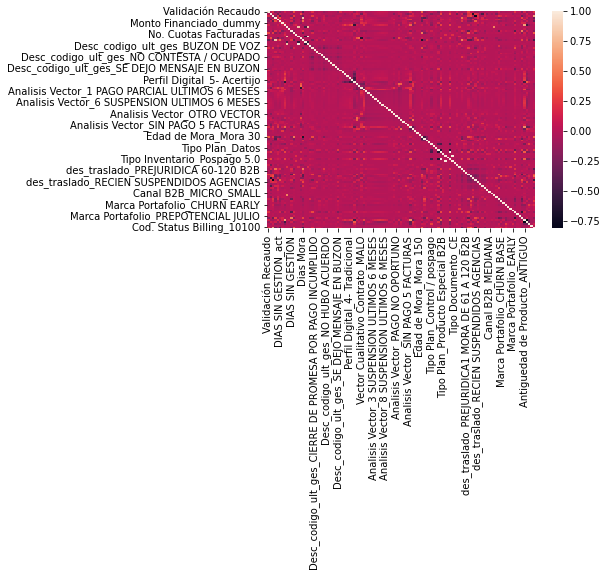

In [27]:
sns.heatmap(variables_consolidadas.corr())

In [28]:
cor=variables_consolidadas.corr().unstack().sort_values().drop_duplicates()
cor=cor.to_frame()
cor=cor.reset_index()
cor.drop_duplicates(['level_0','level_1'],inplace=True)
cor['new']=cor['level_0']==cor['level_1']
cor[(cor['new']!=True) &(cor[0]>0.30)].head(60)#['level_0'].to_list
variables_consolidadas.drop([
                'Mora 330','Mora 120','Mora Mayor 360',
                'Cod. Status Billing_10100',
                'Tipificacion Cliente_nan'],axis=1,inplace=True)
variables_consolidadas['saldo_ratio'].fillna(variables_consolidadas['saldo_ratio'].median(),inplace=True)
variables_consolidadas['saldo_ratio_log']=(variables_consolidadas['saldo_ratio']+1).transform(np.log).fillna((variables_consolidadas['saldo_ratio']+1).transform(np.log).median())
variables_consolidadas['Dias Mora_log']=(variables_consolidadas['Dias Mora']-variables_consolidadas['Dias Mora'].min()+1).transform(np.log)

In [29]:
os.getcwd()


'\\\\10.1.1.7\\01 Oficina Planeación y Control\\01 Analytics\\Stiven\\Movil'

* Importo librerias para modelado

In [30]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,accuracy_score,make_scorer
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV,train_test_split,cross_val_score,KFold,GridSearchCV
from imblearn.combine import SMOTETomek ## Imbalance dataset 
from imblearn.over_sampling import SMOTE

In [31]:
#Entrenamiento y prueba con relación 80:20
x_train, x_test, y_train, y_test = train_test_split(variables_consolidadas,objetivo, test_size=0.25,random_state=90)
#Entrenamiento y validación con relación 90:10
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.1, random_state=90)

print("Shape of x_train:",x_train.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of x_val:",x_val.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test:",y_test.shape)
print("Shape of y_val:",y_val.shape)

Shape of x_train: (90016, 112)
Shape of x_test: (33340, 112)
Shape of x_val: (10002, 112)
Shape of y_train: (90016,)
Shape of y_test: (33340,)
Shape of y_val: (10002,)


In [32]:
# check and remove constant columns
colsToRemove = []
for col in x_train.columns:
    if col != 'ID' and col != 'target':
        if x_train[col].std() == 0: 
            colsToRemove.append(col)
        
# remove constant columns in the training set
x_train.drop(colsToRemove, axis=1, inplace=True)

# remove constant columns in the test set
x_test.drop(colsToRemove, axis=1, inplace=True) 
x_val.drop(colsToRemove, axis=1, inplace=True) 


print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
print(colsToRemove)

Removed `0` Constant Columns

[]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [33]:
%%time
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):
            ia = vs.iloc[:,i].values
            for j in range(i+1, lcs):
                ja = vs.iloc[:,j].values
                if np.array_equal(ia, ja):
                    dups.append(cs[i])
                    break

    return dups

colsToRemove = duplicate_columns(x_train)
print(colsToRemove)

['Tipo Plan_Pospago 5.0', 'Tipo Plan_Venta Plazos']
Wall time: 672 ms


In [34]:
# remove duplicate columns in the training set
x_train.drop(colsToRemove, axis=1, inplace=True) 

x_test.drop(colsToRemove, axis=1, inplace=True) 
# x_val.drop(colsToRemove, axis=1, inplace=True) 


print("Removed `{}` Duplicate Columns\n".format(len(colsToRemove)))
print(colsToRemove)

Removed `2` Duplicate Columns

['Tipo Plan_Pospago 5.0', 'Tipo Plan_Venta Plazos']


In [35]:

sm = SMOTE(random_state = 42)
columns = x_train.columns
## Aplicando el balanceo de datos, solo a la data de entrenamiento
train_data_X,train_data_y=sm.fit_resample(x_train, y_train.values.ravel()) #bien

In [36]:
# train_data_X.columns.to_frame().to_csv('D:\Proyecto Movil\Modelo 2\columnas.csv')

* Modelo inicial
--> Validar sí tiene un comportamiento general
--> ¿cómo mejorer el recall?
--> ¿cómo mejorer la precisión?
--> ¿cúal de ambas se debe optimizar?
--> ¿pará qué cross validation?
--> 

In [37]:
kf = KFold(n_splits=5) ## kfold Cross validation
xgboost = XGBClassifier(max_depth=5,learning_rate=0.001, n_estimators=150, gamma=0.5,colsample_bytree=0.5,subsample=0.6)

model=xgboost.fit(train_data_X, train_data_y)
preds = model.predict(x_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost accuracy es: %3.2f" % (accuracy)) ##
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost accuracy es: 85.05
              precision    recall  f1-score   support

           0       0.94      0.85      0.89     24404
           1       0.67      0.87      0.76      8936

    accuracy                           0.85     33340
   macro avg       0.81      0.86      0.82     33340
weighted avg       0.87      0.85      0.86     33340



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

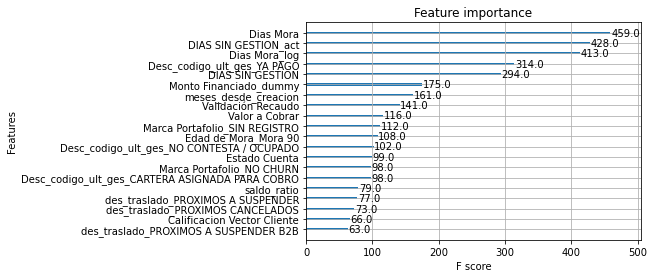

In [38]:
from xgboost import plot_importance
plot_importance(model, max_num_features=20)
#plt.show()

[[20623  3781]
 [ 1204  7732]]


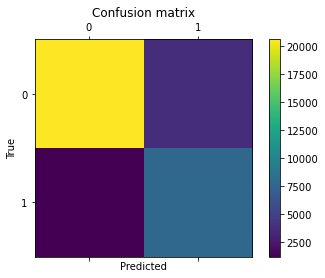

In [39]:
cm = confusion_matrix(y_test, preds)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

** Exporto los pesos del modelo

In [40]:
# import pickle
# file_name = "xgb_mod_1.pkl"
# #D:\Proyecto Movil\Modelo 2\

# # save
# pickle.dump(model, open(file_name, "wb"))


# # load
# xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [41]:
# train_data_X.to_csv("D:\Proyecto Movil\Dataset_x_mod_1.csv",sep=';',encoding='utf-8',index=False)

## Comienza modelo con tuneo

In [42]:
## tuneado de hiper parametros
params={
 "n_estimators"     : [100,150,200],
 "learning_rate"    : [0.005, 0.01, 0.015, 0.0001,0.02 ] ,
 "max_depth"        : [ 6,8,10,15],
 "min_child_weight" : [ 1, 3, 5, 7,5],
 "gamma"            : [ 0.3, 0.4,0.6],
 "colsample_bytree" : [0.5 , 0.7 ,0.9],
 "subsample"        : [0.5,0.8,0.9],
 "reg_lambda"       : [1,2]
 }
scoring = {       'f1_score' : make_scorer(f1_score, average = 'micro')}
kf = KFold(n_splits=3)

In [43]:
xgboost = XGBClassifier(random_state=42)
kf = KFold(n_splits=3)
random_search=RandomizedSearchCV(estimator = xgboost,param_distributions=params,
                                    n_iter=3,scoring='f1_weighted',n_jobs=-1,cv=kf,verbose=3,refit=True)

In [44]:
random_search.fit(train_data_X, train_data_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_ch...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=None),
                  

In [45]:
print(random_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.4, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=2, scale_pos_weight=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)


In [46]:
print("Using hyperparameters --> \n", random_search.best_params_)

Using hyperparameters --> 
 {'subsample': 0.9, 'reg_lambda': 2, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.01, 'gamma': 0.4, 'colsample_bytree': 0.5}


In [47]:
classi=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.4, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=15,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=2, scale_pos_weight=1,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)
model2=classi.fit(train_data_X, train_data_y)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [48]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import pickle
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, accuracy_score
from matplotlib import pyplot



In [49]:
y_hats = model2.predict(x_test)#[:,1]
print(classification_report(y_test, y_hats))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93     24404
           1       0.80      0.87      0.83      8936

    accuracy                           0.91     33340
   macro avg       0.87      0.89      0.88     33340
weighted avg       0.91      0.91      0.91     33340



In [50]:
skf = KFold(n_splits=4)
score=cross_val_score(classi,variables_consolidadas[train_data_X.columns],objetivo,cv=skf,n_jobs=5)

In [52]:
np.mean(score)

0.9085242550608028

In [53]:
# os.chdir(r"D:\Proyecto Movil\Modelo 2")
# model2.save_model("D:\Proyecto Movil\Modelo 2\model2_tun.json")
# 
# file_name = "xgb_mod_v2.pkl"

# # save
# pickle.dump(model2, open(file_name, "wb"))

[[22453  1951]
 [ 1176  7760]]


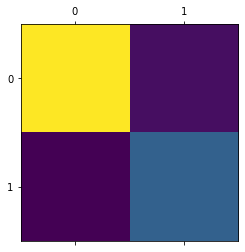

In [54]:
cm = confusion_matrix(y_test, y_hats)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

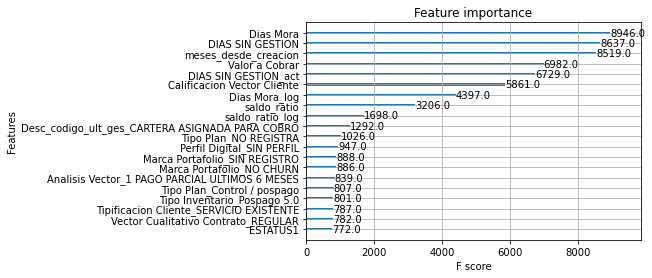

In [55]:
plot_importance(model2, max_num_features=20)

In [56]:
predictions = model2.predict_proba(x_test)[:,1]
roc = roc_auc_score(y_test, predictions)
print("AUC: %.4f%% " % (roc * 100))   # prints AUC: 89.2% 

AUC: 95.5477% 


[[22453  1951]
 [ 1176  7760]]


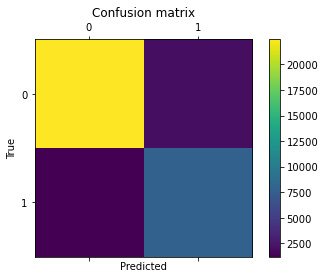

In [57]:
cm = confusion_matrix(y_test, y_hats)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

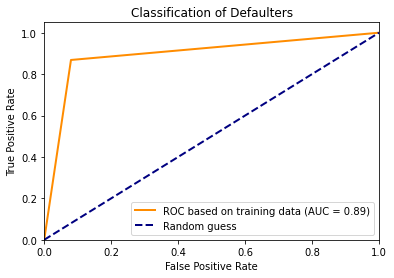

In [58]:
#%matplotlib inline
#Next we plot the ROC curve:
roc_vs = roc_curve(y_test, y_hats)
auc_vs = auc( roc_vs[0], roc_vs[1] )

plt.figure()
line_width = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange', lw=line_width,
         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.93404	validation_0-error:0.10839	validation_0-logloss:0.67997	validation_1-auc:0.92447	validation_1-error:0.12679	validation_1-logloss:0.68033
[1]	validation_0-auc:0.94480	validation_0-error:0.10359	validation_0-logloss:0.66759	validation_1-auc:0.93429	validation_1-error:0.11785	validation_1-logloss:0.66833
[2]	validation_0-auc:0.95488	validation_0-error:0.09557	validation_0-logloss:0.65532	validation_1-auc:0.94552	validation_1-error:0.11029	validation_1-logloss:0.65632
[3]	validation_0-auc:0.95444	validation_0-error:0.09544	validation_0-logloss:0.64433	validation_1-auc:0.94447	validation_1-error:0.11155	validation_1-logloss:0.64564
[4]	validation_0-auc:0.95296	validation_0-error:0.09834	validation_0-logloss:0.63479	validation_1-auc:0.94222	validation_1-error:0.11422	validation_1-logloss:0.63645
[5]	validation_0-auc:0.95137	validation_0-error:0.10282	validation_0-logloss:0.62559	validation_1-auc:0.94016	validation_1-error:0.11815	validation_1-logloss:0.62753
[6]	

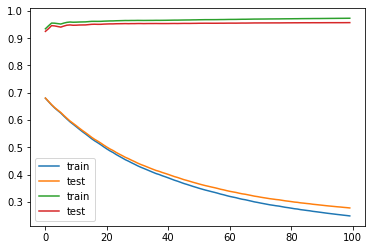

In [59]:
# define the datasets to evaluate each iteration
evalset = [(x_train, y_train), (x_test,y_test)]
# fit the model
eval_metric = ["auc","error","logloss"]

classi.fit(x_train, y_train, eval_metric=eval_metric, eval_set=evalset)
# evaluate performance
yhat = classi.predict(x_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
print('Accuracy: %.3f' % score)

# retrieve performance metrics
results = classi.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
pyplot.plot(results['validation_0']['auc'], label='train')
pyplot.plot(results['validation_1']['auc'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [62]:
## Validación overfitting
# print the scores on training and test set

print('Training set score: {:.4f}'.format(classi.score(x_train, y_train)))

print('Test set score: {:.4f}'.format(classi.score(x_test, y_test)))

Training set score: 0.9285
Test set score: 0.9078


In [61]:
import shap  # package used to calculate Shap values
import matplotlib.pyplot as plt

# Create object that can calculate shap values
explainer = shap.TreeExplainer(classi)

In [63]:
shap_values = explainer.shap_values(x_test) 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
shap.summary_plot(shap_values, x_test)